In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df = df.drop(columns=['customerID'])

In [4]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df['TotalCharges'] = df['TotalCharges'].replace({" ": "0.0"}).astype(float)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df["Churn"].value_counts()
print(f"Class Imbalance ratio: {df['Churn'].value_counts()[0] / df['Churn'].value_counts()[1]:.2f}:1")

Class Imbalance ratio: 2.77:1


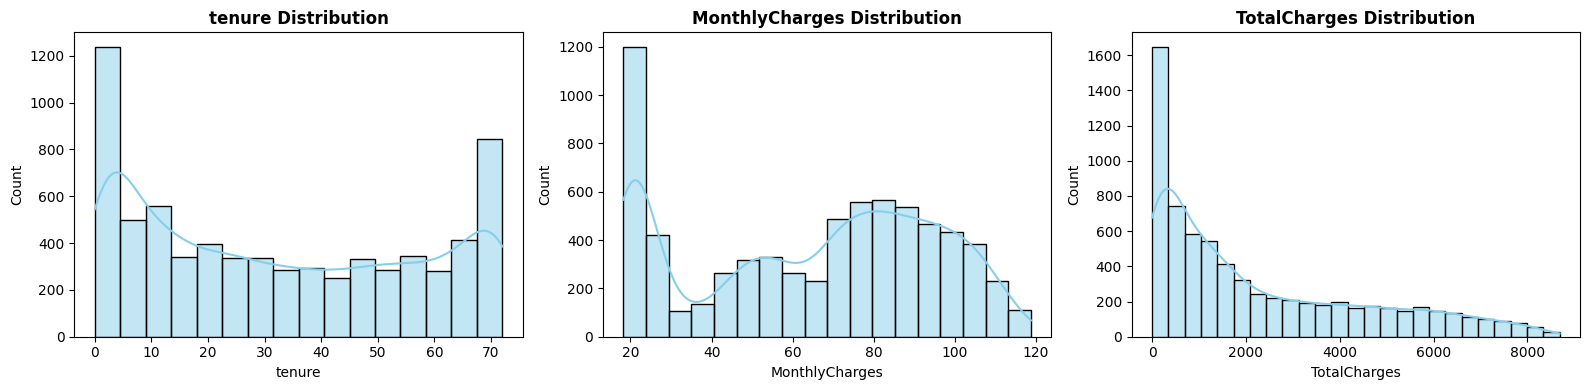

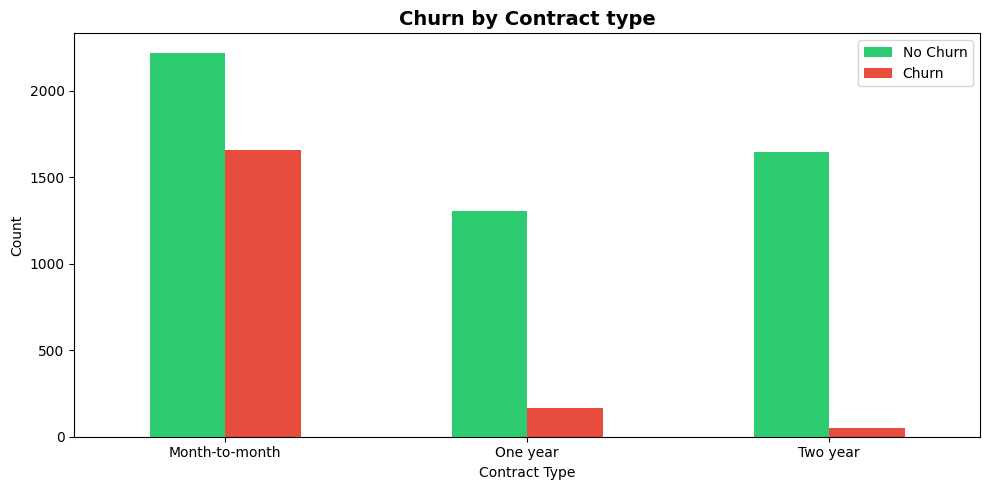

In [8]:
fig , axes = plt.subplots(1, 3, figsize=(16,4))

for idx, col in enumerate(["tenure", "MonthlyCharges","TotalCharges"]):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#churn by contract

fig, ax = plt.subplots(1,1, figsize=(10, 5))
contract_churn = df.groupby(['Contract', 'Churn']).size().unstack(fill_value=0)
contract_churn.plot(kind='bar', stacked=False, ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Churn by Contract type', fontsize=14, fontweight='bold')
ax.set_xlabel('Contract Type')
ax.set_ylabel('Count')
ax.legend(['No Churn', 'Churn'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [9]:
#Encode binary columns

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

categorical_cols = ['MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']

encoders = {}

for col in categorical_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    encoders[col] = encoder

In [10]:
X = df.drop('Churn', axis=1)
Y = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=42)

x_train.shape[0]

5634

In [11]:
x_test.shape[0]

1409

In [12]:
smote = SMOTE(random_state=42)

x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)


#before Smote
dict(y_train.value_counts())

{0: np.int64(4139), 1: np.int64(1495)}

In [13]:
#After Smote
dict(pd.Series(y_train_balanced).value_counts())

{0: np.int64(4139), 1: np.int64(4139)}

In [14]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

xgb_model.fit(x_train_balanced, y_train_balanced)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [15]:
y_train_pred = xgb_model.predict(x_train)
y_test_pred = xgb_model.predict(x_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

In [16]:
print('Training Accuracy', train_acc)
print('Test Accuracy', test_acc)

Training Accuracy 0.8276535321263756
Test Accuracy 0.7679205110007097


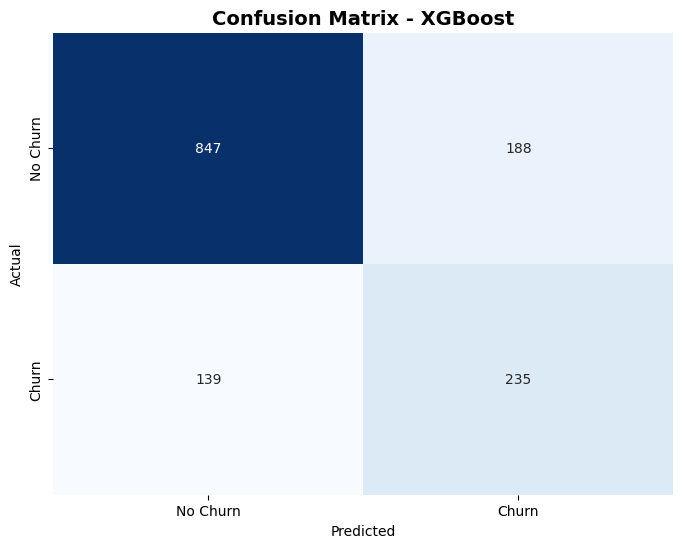

In [17]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])

plt.title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

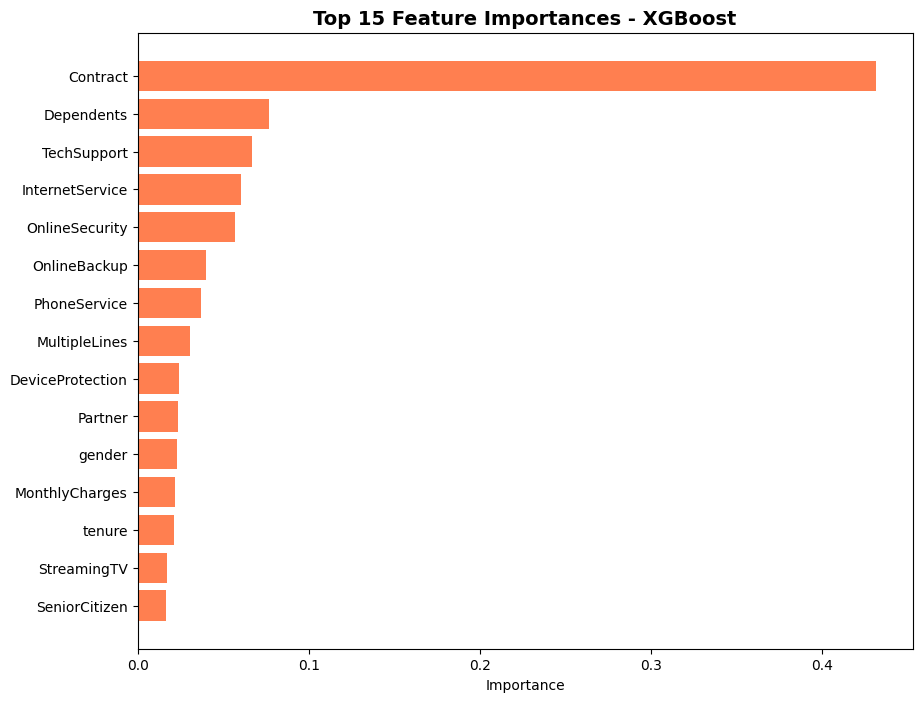

In [18]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance.head(10)

plt.figure(figsize=(10,8))

plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='coral')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

In [19]:
joblib.dump(xgb_model, 'customer_churn_model.pkl')
joblib.dump(encoders, 'churn_encoders.pkl')

['churn_encoders.pkl']